In [42]:
from sklearn.datasets import make_blobs
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator,ClassifierMixin
from abc import ABC, abstractmethod,abstractstaticmethod
from scipy.special import expit
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

In [2]:
def define_axes(X):
  min1,max1 = X[:,0].min(),X[:,0].max()
  min2,max2 = X[:,1].min(),X[:,1].max()
  return [min1-.1,max1+.1,min2-.1,max2+.1]
  
def plotdataset(X,y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    for k in set(y):
        plt.plot(X[:,0][y == k],X[:,1][y==k],'o',alpha=0.3)

def plotPredictions(clf,X):
  axes = define_axes(X)
  x0s = np.linspace(axes[0],axes[1],100)
  x1s = np.linspace(axes[2],axes[3],100)
  x0,x1 = np.meshgrid(x0s,x1s)
  X = np.c_[x0.ravel(),x1.ravel()]
  ypred = clf.predict(X).reshape(x0.shape)
  plt.contourf(x0,x1,ypred,cmap=plt.cm.brg,alpha = 0.2)

In [3]:
def criaDataset(n=200, n_classes=2):
  X, y = make_blobs(n_samples=n, centers=n_classes * 2, cluster_std=0.8)
  
  y = np.array(y % n_classes, dtype= int)
  
  return X, y

In [26]:
X,y = criaDataset(n_classes=3)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=.9)

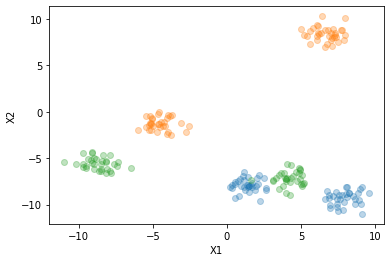

In [27]:
plotdataset(X,y)

# Definições das classes dos algoritmos do exercício

In [6]:
class trainingalgorithm(ABC):
  @abstractmethod
  def getW(self,X,y):
    pass
    
class PseudoInversa(trainingalgorithm):
  def getW(self,X,y):
    return np.linalg.pinv(X) @ y

In [9]:
class Activationfunction(ABC):
  @abstractstaticmethod
  def forward(a):
    pass
  @abstractstaticmethod
  def backward(a):
    pass
  @abstractstaticmethod
  def decision(a):
    pass

In [10]:
class Tanh(Activationfunction):
  @staticmethod
  def forward(a):
    return expit(a)*2-1
  @staticmethod
  def backward(a):
    return (1-np.square(Tanh.forward(a)))
  
  @staticmethod
  def decision(a):
    return (a>=0)*2-1

In [11]:
class Sigmoid(Activationfunction):
  @staticmethod
  def forward(a):
    return expit(a)
  @staticmethod
  def backward(a):
    return Sigmoid.forward(a) * (1-Sigmoid.forward(a))
  
  @staticmethod
  def decision(a):
    return (a>=0.5)*2-1

In [12]:
class Relu(Activationfunction):
  @staticmethod
  def forward(a):
    return a * (a > 0)
  @staticmethod
  def backward(a):
    return (a > 0).astype(np.int8)
  
  @staticmethod
  def decision(a):
    return (a>=0)*2-1

In [13]:
def includebias(X):
    bias = np.ones((X.shape[0],1))
    Xb = np.concatenate((bias,X),axis=1)
    return Xb

class Backpropagation():
  def __init__(self,n_hidden=5,activation=Tanh(),learning_rate=0.001,max_iter=1000):
    self.n_hidden = n_hidden
    self.activation = activation
    self.learning_rate = learning_rate
    self.max_iter = max_iter

  def foward(self,X):
    self.Xb = includebias(X)
    self.pH = self.Xb @ self.wih
    self.H = self.activation.forward(self.pH)
    self.Hb = includebias(self.H)
    self.prey = self.Hb @ self.who
    self.posy = self.activation.forward(self.prey)
    self.ypred = self.activation.decision(self.posy)
    return self.ypred

  def backward(self, y):
    ho_delta = y - self.ypred
    ho_grad = self.Hb.T @ ho_delta
    deriv_grad = self.activation.backward(self.pH)

    ih_delta = (ho_delta @ self.who[1:,:].T)*deriv_grad
  
    ih_grad = self.Xb.T @ ih_delta 
    self.who += ho_grad * self.learning_rate
    self.wih += ih_grad * self.learning_rate

  def fit(self, X, y):
    self.wih = np.random.uniform(-1, 1,  size=(X.shape[1]+1, self.n_hidden))
    self.who = np.random.uniform(-1, 1, size=(self.n_hidden + 1, y.shape[1]))
    for _ in range(self.max_iter):
      self.foward(X)
      self.backward(y)

  def predict(self, X):
      return self.foward(X)


class MLP(BaseEstimator, ClassifierMixin):
  def __init__(self,training_algorithm):
    # training algorithm
    self.training_algorithm = training_algorithm
   
  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels) * 2 -1

  def fit(self, X, y):
    yhot = self.encode_labels(y)
    self.training_algorithm.fit(X, yhot)

  def predict(self, X, y=None):
    a = self.training_algorithm.predict(X)
    if len(self.labels) <=2:
      idx = np.array(a > 0, dtype=int).reshape((-1,))
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

# Utilização da função de ativação Tanh (Não passada como parâmetro, pois é a função padrão)

In [28]:
model = MLP(training_algorithm=Backpropagation(learning_rate=0.009,max_iter=10000))

model.fit(Xtr,ytr)

ypred = model.predict(Xtr)

sum(ytr == ypred)/len(ytr)

1.0

**Plotanto o Treinamento**

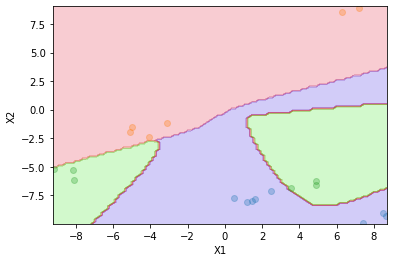

In [29]:
plotdataset(Xtr,ytr)
plotPredictions(model,Xtr)

**Testando e plotando o teste**

In [30]:
ypred = model.predict(Xte,yte)
sum(yte== ypred)/len(yte)

0.9222222222222223

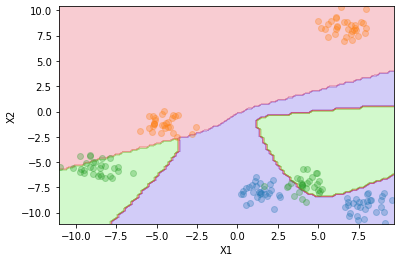

In [31]:
plotdataset(Xte,yte)
plotPredictions(model,Xte)

# Utilização da função de ativação Sigmoid

In [32]:
model = MLP(training_algorithm=Backpropagation(learning_rate=0.009,max_iter=10000,activation=Sigmoid()))

model.fit(Xtr,ytr)

ypred = model.predict(Xtr)

sum(ytr == ypred)/len(ytr)


1.0

**Plotando o treinamento**

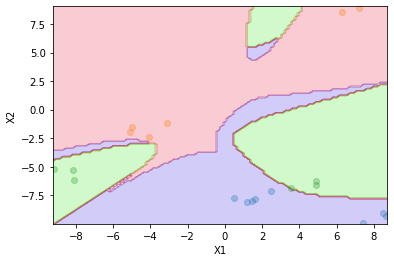

In [33]:
plotdataset(Xtr,ytr)
plotPredictions(model,Xtr)

**Testando e plotando o Teste**

In [34]:
ypred = model.predict(Xte,yte)
sum(yte== ypred)/len(yte)

0.8944444444444445

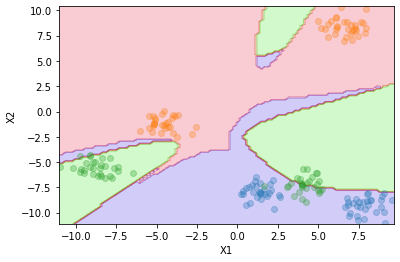

In [35]:
plotdataset(Xte,yte)
plotPredictions(model,Xte)

# Utilização da função de ativação ReLu

In [43]:
model = MLP(training_algorithm=Backpropagation(learning_rate=0.002,max_iter=10000,activation=Relu(),n_hidden=16))

model.fit(Xtr,ytr)

ypred = model.predict(Xtr)

sum(ytr == ypred)/len(ytr)


1.0

**Plotando treinamento**

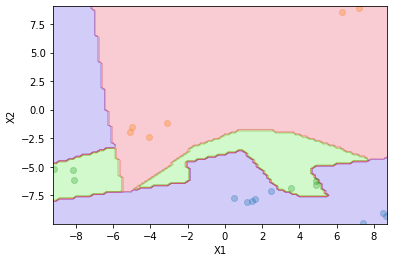

In [44]:
plotdataset(Xtr,ytr)
plotPredictions(model,Xtr)

**Testando e plotando o teste**

In [45]:
ypred = model.predict(Xte,yte)
sum(yte== ypred)/len(yte)

0.9166666666666666

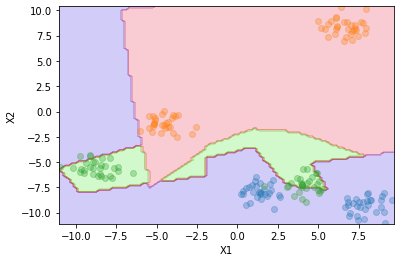

In [46]:
plotdataset(Xte,yte)
plotPredictions(model,Xte)